# Customer Segmentation
#### by Jérôme d'Harveng

<a id='table'></a>
## Table of Contents
<ul>
<li><a href="#encoding">Variables Encoding</a></li>
<li><a href="#dim_reduc">Dimension reduction: t-SNE</a></li>
<li><a href="#kmeans">Unsupervised Clustering: K-means++</a></li>
<li><a href="#prepa">Training and Test set</a></li>
<li><a href="#randomforest">Random forest classifier</a></li>
<li><a href="#Gboost">Gradient Boosting classifier</a></li>
</ul>

### Loading cleaned dataset and importing libraries

In [91]:
# starting by import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.stats as st
import operator
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
import pickle

%matplotlib inline

In [2]:
df_customer_sales = pd.read_csv('RFM_index.csv', sep=",", encoding='utf_8')

In [3]:
df_customer_sales.head(2)

,CustomerID,R,F,M,R_segments,F_segments,M_segments,RFM_score,Country,NuniqueProd
0,12346,325,1,77183.6,4,4,1,441,United Kingdom,1
1,12347,2,182,4310.0,1,1,1,111,Iceland,103


In [4]:
col_segm = ['CustomerID','Country','R_segments', 'F_segments', 'M_segments', 'RFM_score', 
            'NuniqueProd']
df_RFM = df_customer_sales.copy()[col_segm]

In [5]:
df_RFM.head(1)

,CustomerID,Country,R_segments,F_segments,M_segments,RFM_score,NuniqueProd
0,12346,United Kingdom,4,4,1,441,1


In [6]:
col_sales = ['CustomerID','Country','R', 'F', 'M','NuniqueProd']
df_sales = df_customer_sales.copy()[col_sales]
df_sales.head(1)

,CustomerID,Country,R,F,M,NuniqueProd
0,12346,United Kingdom,325,1,77183.6,1


<a id='encoding'></a>
## Variables Encoding

#### Country

##### Define

From the exploration study we remember that round 90% of the sales were from United Kingdom, so for the country variable we'll keep "UK" for United Kingdom and put "Other" for the rest of the countries

##### Code

In [7]:
df_sales['Country_enc'] = df_sales.Country.apply(lambda x: 'UK' if x=="United Kingdom" else "Other")

In [8]:
df_sales.head(1)

,CustomerID,Country,R,F,M,NuniqueProd,Country_enc
0,12346,United Kingdom,325,1,77183.6,1,UK


In [9]:
df_dummies = pd.get_dummies(df_sales['Country_enc'])

In [10]:
df_dummies.head(2)

,Other,UK
0,0,1
1,1,0


In [11]:
print(df_dummies.shape)
print(df_sales.shape)

(4331, 2)
(4331, 7)


> Creation of **df_prepa**

In [12]:
# df_prepa will contain the encoded data for 
df_prepa = df_dummies.copy()
df_prepa['CustomerID'] = df_sales['CustomerID']

#####  Test

In [13]:
print(df_sales.head(5)[['Country','Country_enc']])
print(df_sales.tail(1)[['Country','Country_enc']])

          Country Country_enc
0  United Kingdom          UK
1         Iceland       Other
2         Finland       Other
3           Italy       Other
4          Norway       Other
             Country Country_enc
4330  United Kingdom          UK


In [14]:
# % of sales lines out of UK
(df_sales.query('Country_enc=="UK"').shape[0]/df_sales.shape[0])*100

90.44100669591319

#### Add rest of columns

In [15]:
rest = ['R', 'F', 'M', 'NuniqueProd']
df_prepa[rest] = df_sales[rest]
df_prepa.head(3)

,Other,UK,CustomerID,R,F,M,NuniqueProd
0,0,1,12346,325,1,77183.60,1
1,1,0,12347,2,182,4310.00,103
2,1,0,12348,75,27,1437.24,21


In [16]:
# Rearrange the order of the columns
df_prepa = df_prepa[['CustomerID','Other', 'UK','R', 'F', 'M', 'NuniqueProd']]
print(df_prepa.shape)
df_prepa.head(3)

(4331, 7)


,CustomerID,Other,UK,R,F,M,NuniqueProd
0,12346,0,1,325,1,77183.60,1
1,12347,1,0,2,182,4310.00,103
2,12348,1,0,75,27,1437.24,21


<a id='dim_reduc'></a>
## Dimension Reduction:  t-SNE
<a href="#table">back to content table</a>

In [17]:
# Defining the dataset columns as input for the t-SNE algorithm
X_tsne = df_prepa.iloc[:,1:].values

### Feature scaling

In [18]:
# Before scaling
print("Before scaling",X_tsne[0,:])

#from sklearn.preprocessing import StandardScaler
X_tsneSc = StandardScaler().fit_transform(X_tsne[:,-4:])

# Replacing the scaled columns
X_tsne[:,-4:] = X_tsneSc

# After scaling
print("After scaling",X_tsne[0,:])

Before scaling [0.00000e+00 1.00000e+00 3.25000e+02 1.00000e+00 7.71836e+04 1.00000e+00]
After scaling [ 0.          1.          2.32271186 -0.3971323   8.44031242 -0.70807143]


### t-SNE with different perplexity values

In [19]:
# Additional imports
import matplotlib.pyplot as plt
from sklearn import (manifold, datasets, decomposition, ensemble,discriminant_analysis, random_projection)
from matplotlib import offsetbox

#### Perplexity = 5

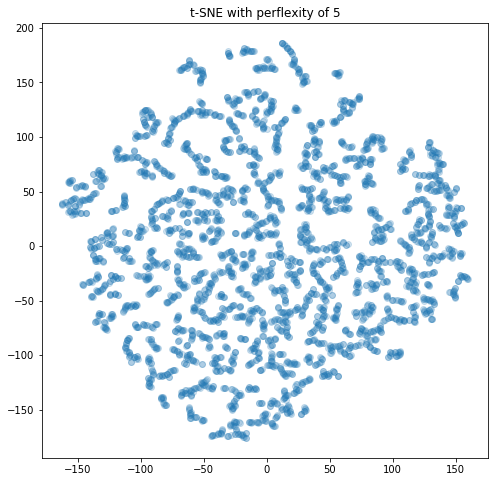

In [20]:
fig = plt.figure(figsize=(8,8))
tsne5 = manifold.TSNE(n_components=2, perplexity=5, n_iter=3000, init='pca')
X_tsne5 = tsne5.fit_transform(X_tsne)
plot_x5 = X_tsne5[:,0]
plot_y5 = X_tsne5[:,1]
plt.scatter(plot_x5, plot_y5,alpha=1/5)
plt.title("t-SNE with perflexity of 5")
plt.show()

#### Perplexity = 10

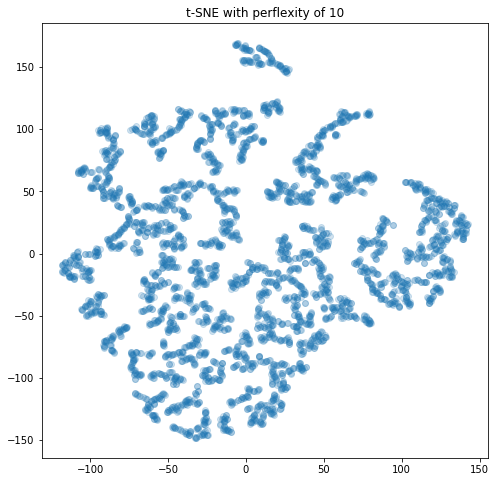

In [21]:
fig = plt.figure(figsize=(8,8))
tsne10 = manifold.TSNE(n_components=2, perplexity=10, n_iter=3000, init='pca')
X_tsne10 = tsne10.fit_transform(X_tsne)
plot_x10 = X_tsne10[:,0]
plot_y10 = X_tsne10[:,1]
plt.scatter(plot_x10, plot_y10,alpha=1/5)
plt.title("t-SNE with perflexity of 10")
plt.show()

#### Perplexity = 20

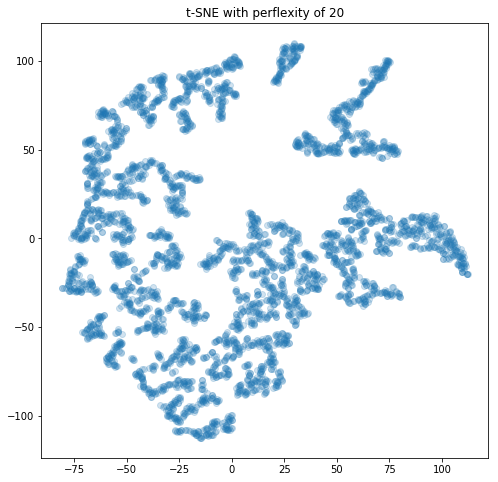

In [22]:
fig = plt.figure(figsize=(8,8))
tsne20 = manifold.TSNE(n_components=2, perplexity=20, n_iter=3000, init='pca')
X_tsne20 = tsne20.fit_transform(X_tsne)
plot_x20 = X_tsne20[:,0]
plot_y20 = X_tsne20[:,1]
plt.scatter(plot_x20, plot_y20,alpha=1/5)
plt.title("t-SNE with perflexity of 20")
plt.show()

#### Perplexity = 30

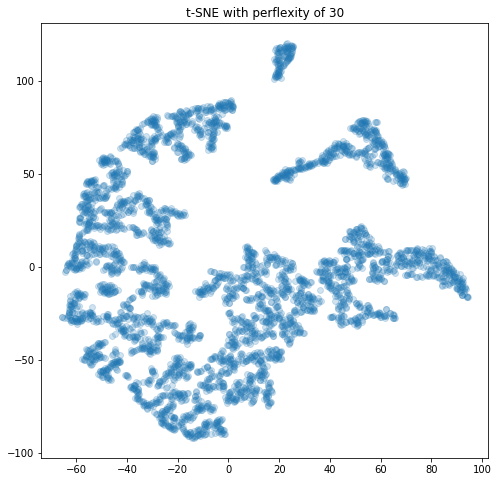

In [23]:
fig = plt.figure(figsize=(8,8))
tsne30 = manifold.TSNE(n_components=2, perplexity=30, n_iter=3000, init='pca')
X_tsne30 = tsne30.fit_transform(X_tsne)
plot_x30 = X_tsne30[:,0]
plot_y30 = X_tsne30[:,1]
plt.scatter(plot_x30, plot_y30,alpha=1/5)
plt.title("t-SNE with perflexity of 30")
plt.show()

#### Perplexity = 40

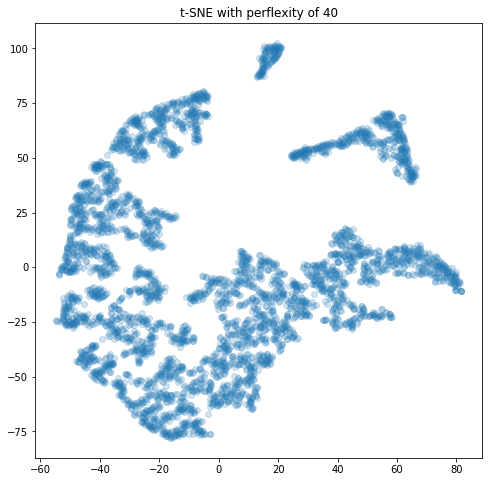

In [24]:
fig = plt.figure(figsize=(8,8))
tsne40 = manifold.TSNE(n_components=2, perplexity=40, n_iter=3000, init='pca')
X_tsne40 = tsne40.fit_transform(X_tsne)
plot_x40 = X_tsne40[:,0]
plot_y40 = X_tsne40[:,1]
plt.scatter(plot_x40, plot_y40,alpha=1/5)
plt.title("t-SNE with perflexity of 40")
plt.show()

#### Perplexity = 50

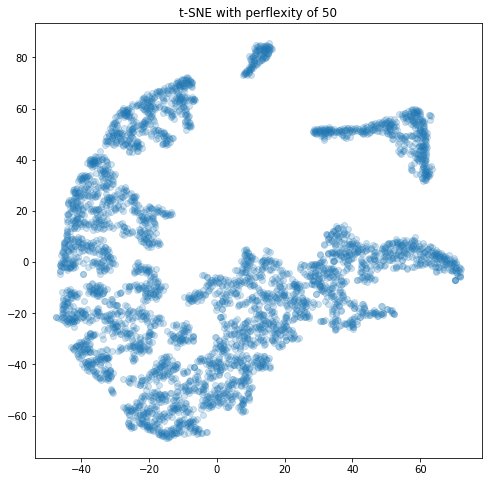

In [25]:
fig = plt.figure(figsize=(8,8))
tsne50 = manifold.TSNE(n_components=2, perplexity=50, n_iter=3000, init='pca')
X_tsne50 = tsne50.fit_transform(X_tsne)
plot_x50 = X_tsne50[:,0]
plot_y50 = X_tsne50[:,1]
plt.scatter(plot_x50, plot_y50,alpha=1/5)
#plt.scatter(plot_x50, plot_y50)
plt.title("t-SNE with perflexity of 50")
plt.show()

### Choice of perplexity based on silhouette value

> to choose the perplexity value, we'll rely on the one giving the highest maximum silhouette coefficient.

In [26]:
X_TSNE = {'perplexity_5': X_tsne5, 'perplexity_10': X_tsne10, 'perplexity_20':X_tsne20,
         'perplexity_30':X_tsne30, 'perplexity_40':X_tsne40, 'perplexity_50':X_tsne50}

Maximum silhouette for perplexity_5
0.41925833
Maximum silhouette for perplexity_10
0.47299677
Maximum silhouette for perplexity_20
0.47313195
Maximum silhouette for perplexity_30
0.47345886
Maximum silhouette for perplexity_40
0.48471063
Maximum silhouette for perplexity_50
0.48455667


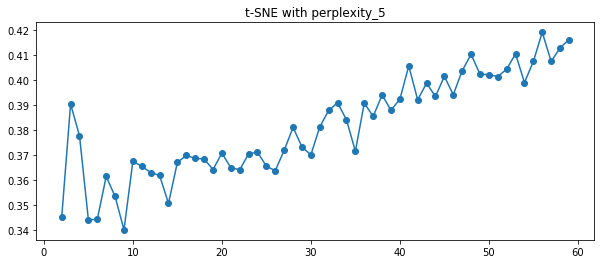

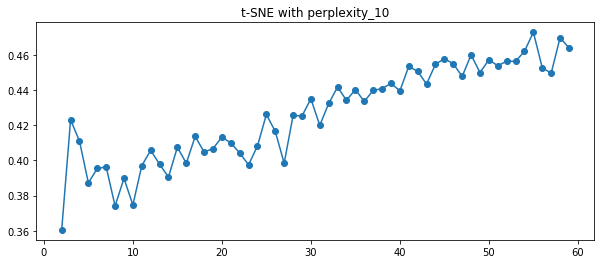

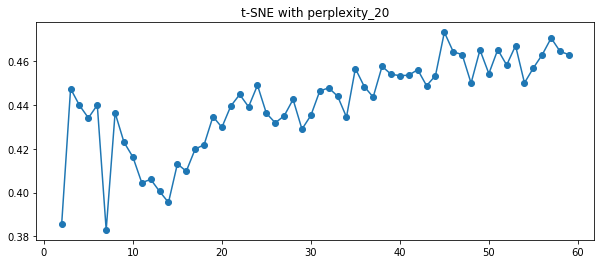

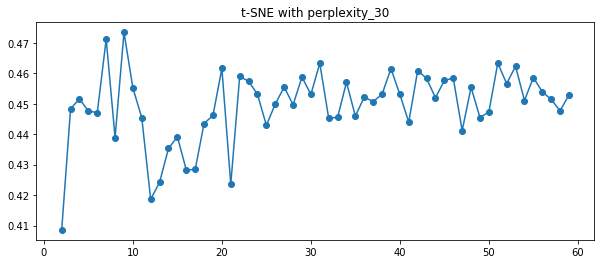

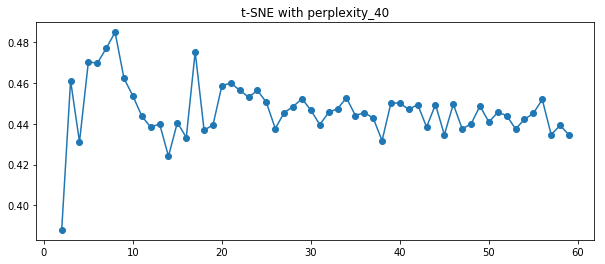

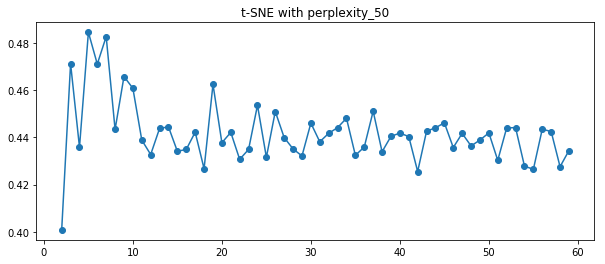

In [27]:
from sklearn import cluster, metrics

#plt.figure(figsize = [20,20])
for perplexity in X_TSNE.keys():
    X_norm = X_TSNE[perplexity]

    fig = plt.figure(figsize=(10,4)) 
    silhouettes = []
    for num_clusters in range(2,60):
        # with unique and randow initialization
        cls = cluster.KMeans(n_clusters = num_clusters,
                        n_init=1,init='k-means++')
        cls.fit(X_norm)
        # computing the shape coefficient
        silh = metrics.silhouette_score(X_norm,cls.labels_)
        silhouettes.append(silh)
    
    print(f'Maximum silhouette for {perplexity}')
    print(max(silhouettes))
    plt.plot(range(2,60),silhouettes, marker='o')
    plt.title(f't-SNE with {perplexity}');

##### Comments:
> -  Perplexity 40, has biggest silhouette coefficient

<a id='kmeans'></a>
## Unsupervised clustering: K-means++
<a href="#table">back to content table</a>

#### Silhouette coefficient for data reduced with perplexity = 40

In [28]:
X_norm = X_tsne40

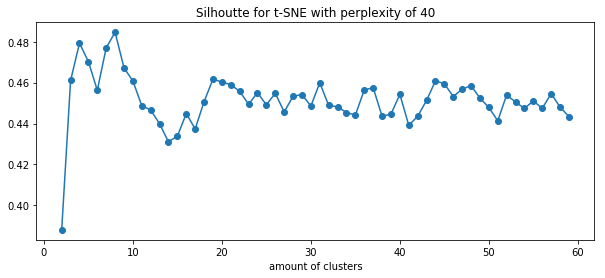

In [29]:
fig = plt.figure(figsize=(10,4))
from sklearn import cluster, metrics
silhouettes = []
for num_clusters in range(2,60):
    # with unique and randow initialization
    cls = cluster.KMeans(n_clusters = num_clusters,
                        init='k-means++')
    cls.fit(X_norm)
    # computing the shape coefficient
    silh = metrics.silhouette_score(X_norm,cls.labels_)
    silhouettes.append(silh)
    
plt.plot(range(2,60),silhouettes, marker='o')
plt.title('Silhoutte for t-SNE with perplexity of 40')
plt.xlabel('amount of clusters');

> The silhouette coefficient has the highest value for 8 clusters

In [30]:
kmeans = cluster.KMeans(n_clusters=8,init='k-means++')
kmeans.fit(X_norm);

In [31]:
X_labels = kmeans.labels_
X_labels.shape

(4331,)

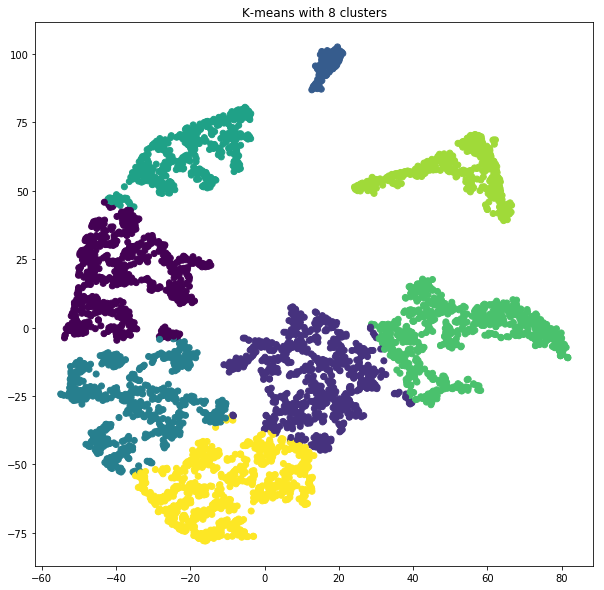

In [32]:
fig = plt.figure(figsize=(10,10))
plt.scatter(X_norm[:,0],X_norm[:,1],c=X_labels)
plt.title("K-means with 8 clusters");

#### Adding K-means labels to df

In [33]:
df_sales['Kmeans'] = X_labels
df_RFM['Kmeans']=X_labels
df_prepa['Kmeans']=X_labels

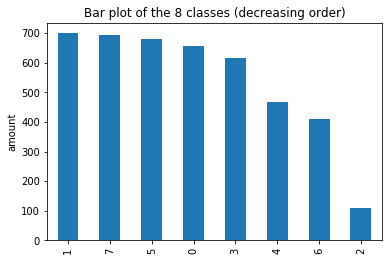

In [34]:
# Distribution of the 8 classes
df_RFM.Kmeans.value_counts().plot(kind='bar')
plt.ylabel('amount')
plt.title('Bar plot of the 8 classes (decreasing order)');

In [35]:
lbl_RFM = {}
for i in range(0,8):
    # Dictionnay with all unique RFM numbers per segmentation class
    lbl_RFM[f'class_{i}'] = df_RFM.query('Kmeans==@i').RFM_score.unique()
    print(f'class_{i} :')
    print(df_RFM.query('Kmeans==@i').RFM_score.value_counts()[:5])
    print('Country')
    print(df_RFM.query('Kmeans==@i').Country.value_counts()[:3])
    print('Number of unique products purchased')
    print(df_prepa.query('Kmeans==@i').NuniqueProd.value_counts()[:5])
    
    print("")

class_0 :
444    105
433     79
322     51
344     49
422     44
Name: RFM_score, dtype: int64
Country
United Kingdom    656
Name: Country, dtype: int64
Number of unique products purchased
1     26
8     18
6     18
13    17
9     17
Name: NuniqueProd, dtype: int64

class_1 :
222    99
122    72
311    55
111    51
211    48
Name: RFM_score, dtype: int64
Country
United Kingdom    699
Name: Country, dtype: int64
Number of unique products purchased
68    19
74    19
66    18
87    17
59    17
Name: NuniqueProd, dtype: int64

class_2 :
444    49
434    15
443    14
433     9
424     9
Name: RFM_score, dtype: int64
Country
United Kingdom    109
Name: Country, dtype: int64
Number of unique products purchased
1    9
3    6
9    6
5    5
7    5
Name: NuniqueProd, dtype: int64

class_3 :
344    124
333    105
343     55
332     54
322     53
Name: RFM_score, dtype: int64
Country
United Kingdom    615
Name: Country, dtype: int64
Number of unique products purchased
6     23
24    22
11    21
23 

In [36]:
df_prepa.head(3)

,CustomerID,Other,UK,R,F,M,NuniqueProd,Kmeans
0,12346,0,1,325,1,77183.60,1,5
1,12347,1,0,2,182,4310.00,103,6
2,12348,1,0,75,27,1437.24,21,6


<a id='prepa'></a>
## Training and Test set
<a href="#table">back to content table</a>

#### Separating in X and y features

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
# Separation into Dependent and independent variables (Features and Labes)
X_features = df_prepa.iloc[:,1:-1].values.astype(float) # not taking the CustomerID in the Xfeatures!
y_features = df_prepa['Kmeans'].values

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_features, test_size=0.2)

#### Scaling numerical data

In [40]:
# before scaling
X_train[0,:]

array([  0.,   1., 191.,  33., 664.,  31.])

In [41]:
# Need to scale the NUMERICAL data on the TRAINING set ONLY
X_train_num = X_train[:, -4:]  
X_test_num = X_test[:, -4:]

scaler = StandardScaler() # create scaler object
scaler.fit(X_train_num) # fit with the training data ONLY
X_train_num_sc = scaler.transform(X_train_num) # Transform the data 
X_test_num_sc = scaler.transform(X_test_num)

# replacing the numerical column (corresponding to DISTANCE) with the scaled values
X_train[:,-4:] = X_train_num_sc
X_test[:,-4:] = X_test_num_sc

In [42]:
# After scaling
X_train[0,:]

array([ 0.        ,  1.        ,  0.99189492, -0.24286288, -0.14430077,
       -0.35251168])

<a id='randomforest'></a>
## Random forest classifier
<a href="#table">back to content table</a>

> **Random forests** is a supervised learning algorithm. It can be used both for classification and regression. A forest is comprised of trees. Random forests creates decision trees on randomly selected data samples, gets prediction from each tree and selects the best solution by means of voting. It also provides a pretty good indicator of the feature importance.


>the most important settings are the **number of trees** in the forest (n_estimators) and the **number of features** considered for splitting at each leaf node (max_features).

> - **max_depth** : the maximum depth of the tree. (integer )
- **min_samples_split** : the minimum number of samples required to split an internal node:
(If int) then consider min_samples_split as the minimum number.
- **min_samples_leaf** : the minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. 
If int, then consider min_samples_leaf as the minimum number.
- **criterion** : the function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 
Note: this parameter is tree-specific.



### Parameter tuning

source: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [43]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

In [44]:
# Choose the type of classifier. 
rf = RandomForestClassifier()

# Parameters to test
param_grid = {'n_estimators': [50,100,150,200], 
              'max_features': [4,5,6], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [3,5,10,15,20], 
              'min_samples_split': [8,10,12],
              'min_samples_leaf': [3,5,8]
             }

# Type of scoring used to compare parameter combinations
accuracy_scor = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(rf, param_grid, scoring=accuracy_scor)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the rf (MODEL with TUNED params) to the best combination of parameters
rf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
rf.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=15, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Cross-Validation and evaluation metrics

source: https://www.kaggle.com/cesartrevisan/scikit-learn-and-gridsearchcv

#### Accuracy

> It is the ratio of number of correct predictions to the total number of input samples. It works well only if there are equal number of samples belonging to each class.

#### Precision, Recall and F-score

> The **precision** is the ratio **tp / (tp + fp)** where **tp is the number of true positives** and **fp the number of false positives**. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

> The **recall** is the ratio **tp / (tp + fn)** where **tp is the number of true positives** and **fn the number of false negatives**. The recall is intuitively the ability of the classifier to find all the positive samples.

> The **F-beta** score can be interpreted as a **weighted harmonic mean of the precision and recall**, where an F-beta score reaches its best value at 1 and worst score at 0.

In [96]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score


def cross_validation(model,num_folds=10):
    kf = KFold(n_splits=num_folds)
    accuracies = []
    precisions = []
    recalls = []
    f_scores = []
    fold = 0
    
    for train_index, test_index in kf.split(X_features):
        fold += 1
        X_train, X_test = X_features[train_index], X_features[test_index]
        y_train, y_test = y_features[train_index], y_features[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Save different metrics
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        metric = precision_recall_fscore_support(y_test, y_pred, average='macro')
        
        precision = metric[0]
        precisions.append(precision)
        recall = metric[1]
        recalls.append(recall)
        f_score = metric[2]
        f_scores.append(f_score)
        print(f"Fold {fold} accuracy: {accuracy}") 
        print(f"Fold {fold} precision: {precision}") 
        print(f"Fold {fold} recall: {recall}") 
        print(f"Fold {fold} F1_score: {f_score}") 
        print("")
        
    mean_accuracy = np.mean(accuracies)
    mean_precision = np.mean(precisions)
    mean_recall = np.mean(recalls)
    mean_fscore = np.mean(f_scores)
    
    
    print("")
    print(f"Mean Accuracy: {mean_accuracy}") 
    print(f"Mean Precision: {mean_precision}")
    print(f"Mean Recall: {mean_recall}")
    print(f"Mean F1_score: {mean_fscore}")
    print("")
    print("")
    

#### Dummy classifier (Baseline comparison)

In [98]:
for strategy in ['stratified', 'most_frequent', 'prior', 'uniform']:
    dummy = DummyClassifier(strategy=strategy)
    dummy.fit(X_train, y_train)
    print(f'Cross-Validation for following strategy : {strategy}')
    cross_validation(dummy,3)

Cross-Validation for following strategy : stratified
Fold 1 accuracy: 0.11842105263157894
Fold 1 precision: 0.11418111699250913
Fold 1 recall: 0.12695883840915265
Fold 1 F1_score: 0.10834963605718825

Fold 2 accuracy: 0.14958448753462603
Fold 2 precision: 0.13858800367680893
Fold 2 recall: 0.1424233884463757
Fold 2 F1_score: 0.13062118658791594

Fold 3 accuracy: 0.13998613998613998
Fold 3 precision: 0.12521023902938472
Fold 3 recall: 0.1394529375372931
Fold 3 F1_score: 0.11762290769839504


Mean Accuracy: 0.13599722671744832
Mean Precision: 0.1259931198995676
Mean Recall: 0.13627838813094048
Mean F1_score: 0.11886457678116641


Cross-Validation for following strategy : most_frequent
Fold 1 accuracy: 0.12465373961218837
Fold 1 precision: 0.015581717451523546
Fold 1 recall: 0.125
Fold 1 F1_score: 0.027709359605911334

Fold 2 accuracy: 0.16759002770083103
Fold 2 precision: 0.02094875346260388
Fold 2 recall: 0.125
Fold 2 F1_score: 0.03588374851720048

Fold 3 accuracy: 0.1787941787941788
Fo

#### Performance for Random forest

In [88]:
cross_validation(rf,5)

Fold 1 accuracy: 0.748558246828143
Fold 1 precision: 0.7529095501949595
Fold 1 recall: 0.915381338160939
Fold 1 F1_score: 0.7899981891973489

Fold 2 accuracy: 0.9780600461893765
Fold 2 precision: 0.9827481250999204
Fold 2 recall: 0.9832665915034502
Fold 2 F1_score: 0.9829552743048984

Fold 3 accuracy: 0.9792147806004619
Fold 3 precision: 0.9840281386192793
Fold 3 recall: 0.9849648860204681
Fold 3 F1_score: 0.9844219681963333

Fold 4 accuracy: 0.976905311778291
Fold 4 precision: 0.9837494519356754
Fold 4 recall: 0.984067534331536
Fold 4 F1_score: 0.983837031426307

Fold 5 accuracy: 0.9745958429561201
Fold 5 precision: 0.9666963957312824
Fold 5 recall: 0.9811020180103571
Fold 5 F1_score: 0.9733533292582479



Mean Accuracy: 0.9314668456704785
Mean Precision: 0.9340263323162235
Mean Recall: 0.9697564736053501
Mean F1_score: 0.942913158476627


#### Feature importance

In [47]:
# feature importance (feature selection)
index_names = df_prepa.columns.tolist()[1:-1]
important_X = pd.Series(rf.feature_importances_,index=index_names).sort_values(ascending=False)
important_X

R              0.494133
F              0.168555
NuniqueProd    0.131017
Other          0.089796
UK             0.089674
M              0.026827
dtype: float64

#### Confusion Matrix

In [48]:
rf.fit(X_train, y_train)
# Compute the predictions on the test set
y_pred=rf.predict(X_test)

In [49]:
# Create confusion matrix
pd.crosstab(y_test, y_pred, rownames=['Actual segments'], colnames=['Predicted Segments'])

Predicted Segments,0,1,2,3,4,5,6,7
Actual segments,,,,,,,,
0,125,1,0,1,0,0,0,0
1,1,124,0,1,0,4,0,1
2,0,0,28,0,0,0,0,0
3,0,4,0,105,0,0,0,3
4,0,0,0,0,96,0,0,0
5,0,2,0,0,0,133,0,0
6,0,0,0,0,0,0,99,0
7,0,1,0,4,0,0,0,134


<a id='Gboost'></a>
## Gradient Boosting classifier
<a href="#table">back to content table</a>

In [50]:
from sklearn.ensemble import GradientBoostingClassifier

https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting
>The **number of weak learners** (i.e. regression trees) is controlled by the parameter **n_estimators**; The **size of each tree** can be controlled either by setting the tree depth via max_depth or by setting the number of leaf nodes via max_leaf_nodes. The **learning_rate** is a hyper-parameter in the range (0.0, 1.0] that controls overfitting via **shrinkage**.

>  **Shrinkage:** a regularization strategy that scales the contribution of each weak learner by a certain factor.
This parameter is also called the **learning rate** because it scales the step length of the gradient descent procedure; it can be set via the learning_rate parameter

### Parameter tuning

source:
https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

> In order to tune boosting parameters, we need to start with some initial values for the other parameters:
- **min_samples_split** = 34 : This should be ~0.5-1% of total values. 
- **min_samples_leaf** = 50 : Can be selected based on intuition. This is just used for preventing overfitting and again a small value because of imbalanced classes.
- **max_depth** = 5 : Should be chosen (5-8) based on the number of observations and predictors. 
- **max_features** = ‘sqrt’ : Its a general thumb-rule to start with square root.
- **subsample** = 0.8 : This is a commonly used used start value

> We'll take the default learning rate of 0.1 and check the **optimum number of trees** for that. For this purpose, we can do a grid search and test out values from 20 to 80 in steps of 10.

**NB:** The **number of weak learners** (i.e. regression trees) is controlled by the parameter **n_estimators**

In [51]:
estimator_gb = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=34,
                                                               min_samples_leaf=50,max_depth=5,max_features='sqrt',
                                                               subsample=0.8,random_state=10)

param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = estimator_gb, param_grid = param_test1,n_jobs=4,
                        iid=False, cv=5)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_sa...      subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': range(20, 81, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [52]:
# Let's check the output
gsearch1.cv_results_

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py

{'mean_fit_time': array([0.5026443 , 0.99595523, 0.97182012, 1.21090245, 1.45605326,
        1.86833491, 2.12801199]),
 'std_fit_time': array([0.06559147, 0.06689422, 0.09872323, 0.04175846, 0.06067433,
        0.13119075, 0.10010401]),
 'mean_score_time': array([0.00477281, 0.00698252, 0.00715227, 0.00907059, 0.0106461 ,
        0.01604986, 0.01668959]),
 'std_score_time': array([0.0007622 , 0.00150234, 0.00021696, 0.00055397, 0.0017618 ,
        0.00500416, 0.00513836]),
 'param_n_estimators': masked_array(data=[20, 30, 40, 50, 60, 70, 80],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 20},
  {'n_estimators': 30},
  {'n_estimators': 40},
  {'n_estimators': 50},
  {'n_estimators': 60},
  {'n_estimators': 70},
  {'n_estimators': 80}],
 'split0_test_score': array([0.94835007, 0.95695839, 0.96413199, 0.96987088, 0.9713056 ,
        0.97704448, 0.97704448]),
 'split1_test_score': array

In [81]:
gsearch1.best_params_,gsearch1.best_score_

({'n_estimators': 60}, 0.9775137817929496)

>60 seems to be the best estimator

#### Tuning Tree specific parameters

>Following steps:
- Tune **max_depth** and **num_samples_split**
- Tune **min_samples_leaf**
- Tune **max_features**
- The order of tuning variables is important. Variables with a higher impact on outcome, should be tuned first. For instance, **max_depth** and **min_samples_split** have a significant impact and we’re tuning those first.

>We’ll test **max_depth** values of 5 to 8 in steps of 1 and **min_samples_split** from 30 to 230 in steps of 50. 

In [53]:
# for n_estimators we keep the 60 found before
estimator_gb2 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_features='sqrt',
                                           subsample=0.8, random_state=10)
param_test2 = {'max_depth':range(5,9), 'min_samples_split':range(30,231,50)}
gsearch2 = GridSearchCV(estimator = estimator_gb2, param_grid = param_test2,n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sam...      subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': range(5, 9), 'min_samples_split': range(30, 231, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [54]:
# Let's check the output
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py

({'mean_fit_time': array([1.97462301, 1.89166355, 1.32757025, 1.56279979, 1.27573247,
         1.79831095, 1.78574862, 1.8164536 , 1.63135448, 1.89527225,
         2.84586158, 1.95767102, 1.88977518, 2.17598648, 1.71806588,
         3.2180532 , 2.41148906, 2.12660875, 2.21769319, 1.69557424]),
  'std_fit_time': array([0.19269188, 0.41369278, 0.03526343, 0.14803834, 0.03201644,
         0.04110759, 0.05606598, 0.05162865, 0.036563  , 0.20604148,
         0.08327407, 0.27190303, 0.10024255, 0.11579524, 0.07068795,
         0.19410295, 0.09593483, 0.10007642, 0.17210258, 0.1377455 ]),
  'mean_score_time': array([0.01316381, 0.01417646, 0.01016436, 0.01017537, 0.00963135,
         0.01246552, 0.01215034, 0.01322093, 0.0114316 , 0.01742554,
         0.01676183, 0.0137259 , 0.01454663, 0.01629934, 0.01543779,
         0.02048893, 0.01807919, 0.0196557 , 0.01502204, 0.01252193]),
  'std_score_time': array([0.00471026, 0.00650556, 0.0011083 , 0.00068133, 0.00026611,
         0.00042663, 0.0004

> Optimal values within the given parameters seem:
- max_depth = 8
- min_samples_split = 30

In [55]:
param_test3 = {'min_samples_leaf':range(20,61,10)}
estimator_gb3 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, min_samples_split=30,max_depth=8,
                                           max_features='sqrt', subsample=0.8, random_state=10)
gsearch3 = GridSearchCV(estimator = estimator_gb3, param_grid = param_test3, n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sam...      subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'min_samples_leaf': range(20, 61, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [56]:
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py

({'mean_fit_time': array([2.41858582, 2.16837707, 2.00002909, 1.77201762, 1.66357427]),
  'std_fit_time': array([0.16000543, 0.33474204, 0.29811181, 0.05536362, 0.26908645]),
  'mean_score_time': array([0.0193748 , 0.02340217, 0.01640697, 0.01597443, 0.01491632]),
  'std_score_time': array([0.00292955, 0.00884273, 0.00329285, 0.0024569 , 0.0013272 ]),
  'param_min_samples_leaf': masked_array(data=[20, 30, 40, 50, 60],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'min_samples_leaf': 20},
   {'min_samples_leaf': 30},
   {'min_samples_leaf': 40},
   {'min_samples_leaf': 50},
   {'min_samples_leaf': 60}],
  'split0_test_score': array([0.97704448, 0.97560976, 0.96843615, 0.97704448, 0.9713056 ]),
  'split1_test_score': array([0.98124098, 0.98268398, 0.98268398, 0.98124098, 0.98268398]),
  'split2_test_score': array([0.97691198, 0.97546898, 0.97402597, 0.97113997, 0.97113997]),
  'split3_test_score': array([0.976

> Optimal values within the given parameters seem:
- min_samples_leaf = 30

In [57]:
param_test4 = {'max_features':range(3,7)}
estimator_gb4 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=8, min_samples_split=30,
                                           min_samples_leaf=30,subsample=0.8, random_state=10)
gsearch4 = GridSearchCV(estimator = estimator_gb4,param_grid = param_test4,n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=30, min_samp...      subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_features': range(3, 7)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [58]:
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py

({'mean_fit_time': array([2.41782374, 2.46391521, 2.33316612, 2.837887  ]),
  'std_fit_time': array([0.02485871, 0.20308033, 0.03387108, 0.17372706]),
  'mean_score_time': array([0.0157577 , 0.0146956 , 0.01509023, 0.01564307]),
  'std_score_time': array([0.00154636, 0.001374  , 0.00103971, 0.00206214]),
  'param_max_features': masked_array(data=[3, 4, 5, 6],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_features': 3},
   {'max_features': 4},
   {'max_features': 5},
   {'max_features': 6}],
  'split0_test_score': array([0.97417504, 0.97991392, 0.97560976, 0.97704448]),
  'split1_test_score': array([0.98412698, 0.98268398, 0.98412698, 0.98124098]),
  'split2_test_score': array([0.97835498, 0.97691198, 0.97546898, 0.98124098]),
  'split3_test_score': array([0.97684515, 0.98263386, 0.98552822, 0.98408104]),
  'split4_test_score': array([0.98695652, 0.98115942, 0.98405797, 0.98405797]),
  'mean_test_score': array(

> best match seems with :
- max_features = 6

### Cross-Validation and several metrics

In [59]:
gboosting = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=8, min_samples_split=30,
                                           min_samples_leaf=30,subsample=0.8,max_features=6, random_state=10)

#### Accuracy

> It is the ratio of number of correct predictions to the total number of input samples. It works well only if there are equal number of samples belonging to each class.

#### Precision, Recall and F-score

> The **precision** is the ratio **tp / (tp + fp)** where **tp is the number of true positives** and **fp the number of false positives**. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

> The **recall** is the ratio **tp / (tp + fn)** where **tp is the number of true positives** and **fn the number of false negatives**. The recall is intuitively the ability of the classifier to find all the positive samples.

> The **F-beta** score can be interpreted as a **weighted harmonic mean of the precision and recall**, where an F-beta score reaches its best value at 1 and worst score at 0.

In [89]:
cross_validation(gboosting,5)

Fold 1 accuracy: 0.9907727797001153
Fold 1 precision: 0.988464907323689
Fold 1 recall: 0.9916364918883953
Fold 1 F1_score: 0.9899366079643871

Fold 2 accuracy: 0.9792147806004619
Fold 2 precision: 0.9834955684203905
Fold 2 recall: 0.9839165202783791
Fold 2 F1_score: 0.9836738950031703

Fold 3 accuracy: 0.9849884526558892
Fold 3 precision: 0.9887940561500539
Fold 3 recall: 0.9892897045735954
Fold 3 F1_score: 0.9890063267835862

Fold 4 accuracy: 0.9838337182448037
Fold 4 precision: 0.9882812145409644
Fold 4 recall: 0.9887511620136091
Fold 4 F1_score: 0.9884707285362999

Fold 5 accuracy: 0.9699769053117783
Fold 5 precision: 0.9634918493361517
Fold 5 recall: 0.977214053100859
Fold 5 F1_score: 0.9697153463145014



Mean Accuracy: 0.9817573273026097
Mean Precision: 0.9825055191542498
Mean Recall: 0.9861615863709675
Mean F1_score: 0.9841605809203889


# Confusion Matrix

In [61]:
gboosting.fit(X_train, y_train)
# Compute the predictions on the test set
y_pred_gb=gboosting.predict(X_test)

In [62]:
# Create confusion matrix
pd.crosstab(y_test, y_pred_gb, rownames=['Actual segments'], colnames=['Predicted Segments'])

Predicted Segments,0,1,2,3,4,5,6,7
Actual segments,,,,,,,,
0,125,1,0,1,0,0,0,0
1,1,124,0,1,0,4,0,1
2,0,0,28,0,0,0,0,0
3,0,1,0,108,0,0,0,3
4,0,0,0,0,96,0,0,0
5,0,1,0,0,0,134,0,0
6,0,0,0,0,0,0,99,0
7,0,1,0,3,0,0,0,135


### Exportation model

In [66]:
# Need to save the scaler for the standardization
filename_scal = 'scaler.sav'
pickle.dump(scaler, open(filename_scal, 'wb'))

In [67]:
# export Ridge and Lasso models
filename_rf = 'randomF_model.sav'
filename_gb = 'gradientB_model.sav'
pickle.dump(rf, open(filename_rf, 'wb'))
pickle.dump(gboosting, open(filename_gb, 'wb'))